The reference primitives in the Qiskit SDK perform local statevector simulations. It does not support modeling device noise, but are useful for quickly prototyping algorithms before looking into more advanced simulation techniques  

The Estimator can compute expecation values of circuits, and the Sampler can sample from output distributions of circuits 

# Use the reference Estimator  
```EstimatorV2``` in ```qiskit.primitives``` that runs on a local statevector simulations is the ```StatevectorEstimator``` class. It can take circuits, observables, and parameters as inputs and returns the locally computed exp values  

The expected input type for the observables is ```qiskit.quantum_info.SparsePauliOp```. 

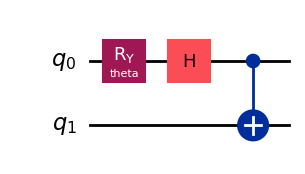

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

qc = QuantumCircuit(2)
qc.ry(Parameter('theta'), 0)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

In [3]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
 
# observable(s) whose expected values you want to compute
 
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])
 
# value(s) for the circuit parameter(s)
parameter_values = [[0], [np.pi / 6], [np.pi / 2]]

**Transpile to ISA circuits and observables**  
The Qiskit Runtime primitives workflow requires circuits and observables to be transformed to only use instructions supporte by the QPU(referred to as *instruction set architecture(ISA)* circuits and observables). The reference primitives still accept abstract instructions, as they rely on local statevector simulations, but transpiling the circuit might still be beneficial in terms of circuit optimization  


In [ ]:
from qiskit.transpiler import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level = 0)
isa_circuit = pm.run(qc)
isa_observable = observable.apply_layout(isa_circuit.layout)

Initialize Estimator

In [12]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

Run and get results  
Run the estimation by calling the ```StatevectorEstimator.run``` method, which return an instances of a ```PrimitiveJob``` object. You can get the results from the job (as ```qiskit.primitives.PrimitiveResult``` object) with ```qiskit.primitives.PrimitiveJob.result``` method.

In [22]:
job = estimator.run([(isa_circuit, isa_observable, parameter_values)])
# job = estimator.run([(qc, observable, parameter_values)])
result = job.result()
print(f"> Result class: {type(result)}")

> Result class: <class 'qiskit.primitives.containers.primitive_result.PrimitiveResult'>


The primitive result outputs an array of ```PubResults```s, where each item of the array is a ```PubResult``` object that contains in its data the array of evaluations corresponding to every circuit-observable combination in the PUB   

In [26]:
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

 > Expectation value: [4.         3.73205081 2.        ]
 > Metadata: {'target_precision': 0.0, 'circuit_metadata': {}}


By default, the reference Estimator performs an exact statevector calculation based on the ```quantum_info.Statevector``` class, However, this can be modified to introduce the effect of the sampling overhead (also known as "shot noise")  
Estimator accepts a ```precision``` argument taht expressese the error bars that the primitive implementation should target for exp values estimates. This is the sampling overhead and is defined exclusively in the ```.run()``` method. This lets you fine-tune the option all the way to the PUB level

In [29]:
# Estimate expectation values for two PUBs, both with 0.05 precision.
precise_job = estimator.run(
    [(isa_circuit, isa_observable, parameter_values)], precision=0.05
)
precise_result = precise_job.result()
print(f" > Expectation value: {precise_result[0].data.evs}")
print(f" > Metadata: {precise_result[0].metadata}")

 > Expectation value: [3.97027131 3.78729686 2.12373055]
 > Metadata: {'target_precision': 0.05, 'circuit_metadata': {}}


# Use the reference Sampler  


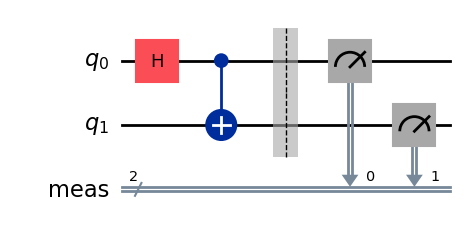

In [30]:
from qiskit import QuantumCircuit
 
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
circuit.draw("mpl", style="iqp")

* Note: Any quantum circuit passed to a Sampler **must** include measurements  

In [31]:
# Generate a pass manager without providing a backend
from qiskit.transpiler import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit = pm.run(qc)

Initialize ```SamplerV2```

In [ ]:
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()

In [33]:
# execute 1 circuit with Sampler
job = sampler.run([circuit])
pub_result = job.result()[0]
print(f" > Result class: {type(pub_result)}")

 > Result class: <class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>


Primitives accept multiple PUBs as inputs, and each PUB gets its own result. Therefore, you can run different circuits with various parameter/observables combinations, and retrieve the PUB results:

In [34]:
from qiskit.transpiler import generate_preset_pass_manager
 
# create two circuits
circuit1 = circuit.copy()
circuit2 = circuit.copy()
 
# transpile circuits
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit1 = pm.run(circuit1)
isa_circuit2 = pm.run(circuit2)
# execute 2 circuits using Sampler
job = sampler.run([(isa_circuit1), (isa_circuit2)])
pub_result_1 = job.result()[0]
pub_result_2 = job.result()[1]
print(f" > Result class: {type(pub_result)}")

 > Result class: <class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>


Measurement outcome samples are returned as **bitstrings** or **counts**. The Sampler result objects organize data in terms of their input circuits' classical register names, for compatibility with dynamic circuit.  
The name of the classical register defaults to ```meas```. This name will be used later to access the measurement bitstrings

In [ ]:
# Transpile circuit
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit = pm.run(circuit)

# Run using sampler
result = sampler.run([isa_circuit]).result()
# Access result data for PUB 0
data_pub = result[0].data

# Access bitstring for the classical register "meas"
bitstrings = data_pub.meas.get_bitstrings() # 비트스트링 나온거 전부
print(f"The number of bitstrings is: {len(bitstrings)}")

# Get counts for the classical register "meas" 
counts = data_pub.meas.get_counts() # 통계를 사전으로 반환
print(f"The counts are: {counts}")

The number of bitstrings is: 1024
The counts are: {'11': 510, '00': 514}


By default, Sampler performs an exact statevector calculation based on the ```quantum_info.Statevector`. The Sampler interface accepts a ```shots``` argument that can be defined at the PUB level.

In [54]:
# Sample two circuits at 128 shots each.
sampler.run([isa_circuit1, isa_circuit2], shots=128)
# Sample two circuits at different amounts of shots. The "None"s are necessary
# as placeholders

# for the lack of parameter values in this example. None으로 파라미터가 없음을 명시해 줘야함
res = sampler.run([(isa_circuit1, None, 123), (isa_circuit2, None, 456)])
res1 = res.result()[0]
res2 = res.result()[1]
print(f" > Result class for PUB 1: {type(res1)}")
print(f" > Result class for PUB 2: {type(res2)}")

print(f"The number of bitstrings for PUB 1 is: {len(res1.data.meas.get_bitstrings())}")
print(f"The number of bitstrings for PUB 2 is: {len(res2.data.meas.get_bitstrings())}")

print(f"The counts for PUB 1 are: {res1.data.meas.get_counts()}")
print(f"The counts for PUB 2 are: {res2.data.meas.get_counts()}")

 > Result class for PUB 1: <class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>
 > Result class for PUB 2: <class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>
The number of bitstrings for PUB 1 is: 123
The number of bitstrings for PUB 2 is: 456
The counts for PUB 1 are: {'00': 59, '11': 64}
The counts for PUB 2 are: {'11': 225, '00': 231}
